In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/anonymized_bsc_dataPVZ.csv')

/Users/clementinelacey/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,20,21,23,24,26,27,29,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
0,15/SP,DA 101 A,Basic Ballet,F,0.5,3.0,W,3.0,3.667,Melissa Turnage,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
1,15/SP,HI 155 A-ES,Reforming America,F,1.0,NaN,A-,3.0,3.667,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
2,15/SP,PL 200 A-CI,Ethical Choice,F,1.0,NaN,B+,3.0,3.667,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
3,15/SP,IDS 200 A-CI,Intro to Human Rights (GP),F,1.0,NaN,A,3.0,3.667,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
4,15/WI,GEN E299 49,Exploration Project,F,1.0,1.0,S,1.0,0.000,Vincent Gawronski,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51537 entries, 0 to 51536
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sttr Term              51518 non-null  object 
 1   course_#               51518 non-null  object 
 2   course_title           51518 non-null  object 
 3   Sttr Student Load      51417 non-null  object 
 4   Sttr Stu Credits       51479 non-null  float64
 5   Sttr Attempted Cred    46383 non-null  float64
 6   Sttr Stu Final Grades  51518 non-null  object 
 7   Sttr Cmpl Cred         51417 non-null  float64
 8   Sttr Term Gpa          51417 non-null  float64
 9   faculty                51478 non-null  object 
 10  alt_id                 51518 non-null  float64
 11  Cohort                 51537 non-null  object 
 12  SP1 Enr                50912 non-null  object 
 13  SP1 Class              50912 non-null  float64
 14  SP1 Major              40420 non-null  object 
 15  FA

## Graduated works for 2014-2018 ##

In [5]:
#features = df.drop('Graduated', axis =1)
#X = features
#y = df.Graduated

In [6]:
df.tail(19)

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
51518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
51527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


## Dropping the last 19 rows ##

In [7]:
df.drop(df.index[51518:51537], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51518 entries, 0 to 51517
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sttr Term              51518 non-null  object 
 1   course_#               51518 non-null  object 
 2   course_title           51518 non-null  object 
 3   Sttr Student Load      51417 non-null  object 
 4   Sttr Stu Credits       51479 non-null  float64
 5   Sttr Attempted Cred    46383 non-null  float64
 6   Sttr Stu Final Grades  51518 non-null  object 
 7   Sttr Cmpl Cred         51417 non-null  float64
 8   Sttr Term Gpa          51417 non-null  float64
 9   faculty                51478 non-null  object 
 10  alt_id                 51518 non-null  float64
 11  Cohort                 51518 non-null  object 
 12  SP1 Enr                50911 non-null  object 
 13  SP1 Class              50911 non-null  float64
 14  SP1 Major              40419 non-null  object 
 15  FA

In [9]:
df.tail(19)

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
51499,21/SP,EH 205 A-CE,Intro to Creative Writing,F,1.00,4.5,A,4.5,3.982,Melinda Thompson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51500,21/SP,MU 152 A,Theory II,F,0.75,4.5,A,4.5,3.982,Rebecca Remley,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51501,21/SP,MU 155 A,Ear Training II,F,0.25,4.5,A-,4.5,3.982,Christopher Harris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51502,21/SP,PH 122 A,General Physics II,F,1.00,4.5,A,4.5,3.982,Duane Pontius,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51503,21/SP,MS 350 E,Saxophone,F,0.50,4.5,A,4.5,3.982,Robert Janssen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51504,20/SP,HI 212 A-ES,Hamilton's America,F,1.00,2.0,D,1.0,0.500,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51505,20/SP,PL 252 A-IA,Modern Philosophy,F,1.00,2.0,U,1.0,0.500,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51506,20/SP,EH 102 J,Sem Critical Thinking Writing,F,1.00,2.0,F,1.0,0.500,Timothy Tipton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51507,20/FA,THA 120 B-CE,Beginning Acting,F,1.00,3.0,F,0.0,0.000,Alan Litsey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51508,20/FA,PY 101 A,Introduction to Psychology,F,1.00,3.0,F,0.0,0.000,Kyle Kraemer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are investigating outliers.

In [10]:
dfIDS = pd.DataFrame(df.alt_id.value_counts(ascending=False))

In [11]:
dfIDS.tail(70)

,alt_id
2063.0,4
161.0,4
2479.0,3
3168.0,3
1219.0,3
...,...
1732.0,3
2388.0,3
2085.0,3
2262.0,3


In [12]:
df.loc[(df['alt_id'] == 2902.0)]

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
46919,18/FA,IDS 101 A,What Best College Student,P,0.5,0.5,D,0.5,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46920,19/SU,UES 150 A-SM,Intro Environmental Studies,F,1.0,2.0,B,2.0,2.5,Mary Kamber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#changed dataframe
    #used to be set to df_4 but now df

df = df.loc[(df['Cohort'] == '14/FA') | (df['Cohort'] == '15/FA') | (df['Cohort'] == '16/FA')
              | (df['Cohort'] == '17/FA')]
df = df.dropna(subset=['Sttr Term'])
df

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
0,15/SP,DA 101 A,Basic Ballet,F,0.5,3.0,W,3.0,3.667,Melissa Turnage,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
1,15/SP,HI 155 A-ES,Reforming America,F,1.0,NaN,A-,3.0,3.667,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
2,15/SP,PL 200 A-CI,Ethical Choice,F,1.0,NaN,B+,3.0,3.667,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
3,15/SP,IDS 200 A-CI,Intro to Human Rights (GP),F,1.0,NaN,A,3.0,3.667,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
4,15/WI,GEN E299 49,Exploration Project,F,1.0,1.0,S,1.0,0.000,Vincent Gawronski,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41079,18/FA,EH 102 A,Sem Critical Thinking Writing,F,1.0,3.0,B,3.0,3.667,Jane Archer,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
41080,19/SP,MFS 220 A-CE,Film Production I,F,1.0,4.0,A,4.0,2.500,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
41081,19/SP,PY 101 C,Introduction to Psychology,F,1.0,NaN,C,4.0,2.500,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
41082,19/SP,MU 114 A-CE,Class Voice,F,1.0,NaN,B,4.0,2.500,Paul Wolf,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


## Checking for Course Title Duplicates ##

In [14]:
print(df['course_title'].value_counts())

Exploration Project              3097
Sem Critical Thinking Writing    1210
Introduction to Psychology        973
Calculus I                        660
Introduction to Sociology         651
                                 ... 
Conversation Comp Grammar           1
Serpents, Siblings, Sacrifice       1
Intro to French II                  1
Pre-Columbian Art                   1
Tchg Experience in MFS              1
Name: course_title, Length: 952, dtype: int64


In [15]:
print(df.nunique())

Sttr Term                  24
course_#                 1721
course_title              952
Sttr Student Load           5
Sttr Stu Credits            7
Sttr Attempted Cred        23
Sttr Stu Final Grades      19
Sttr Cmpl Cred             24
Sttr Term Gpa             789
faculty                   292
alt_id                   1455
Cohort                      4
SP1 Enr                     4
SP1 Class                   3
SP1 Major                  25
FA2 Enr                     4
FA2 Class                   4
FA2 Major                  28
FA3 Enr                     4
FA3 Class                   4
FA3 Major                  36
FA4 Enr                     4
FA4 Class                   3
FA4 Major                  43
FA5 Enr                     3
FA5 Class                   3
FA5 Major                  20
FA6 Enr                     2
FA6 Class                   1
FA6 Major                   5
Graduated                   2
Grad Term                  16
Grad Year                   5
Grad Major

## One Hot Encoding Course Title ##

In [16]:
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray

In [17]:
    #data = df_4[['course_title']]
#encoder = OneHotEncoder(handle_unknown='ignore')
    #encoded = OneHotEncoder(sparse=False)
#encoder.fit(df)
    #encoded_df = encoded.fit_transform(data)
#df_encoded = encoder.transform(df)
    #encoded_df

In [18]:
#ohe = OneHotEncoder()
#dummies = ohe.fit_transform(df_4[['course_title']])
#dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(), index=df_4.index)
#ohe_df = pd.concat([df_4, dummies_df], axis=1)

#### Do not need to label encoder ####

In [19]:
#from sklearn.preprocessing import LabelEncoder

In [20]:
#le = LabelEncoder()

In [21]:
#le.fit(df['course_title'])

In [22]:
#df['course_title'] = le.transform(df['course_title'])

In [23]:
#df

## Creating Target and Feature Variables ##

In [24]:
from sklearn.model_selection import train_test_split

y = df['Graduated']
X = df.drop(columns=['Graduated'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021)

## Changing Graduation to no being 0 and yes being 1 ##

In [25]:
#recode the graduation column so that N = 0 & Y = 1
mapping = {'N': 0, 'Y': 1}
df['Graduated'] = df['Graduated'].map(mapping)

In [26]:
target = df['Graduated']
target

0        1
1        1
2        1
3        1
4        1
        ..
41079    0
41080    0
41081    0
41082    0
41083    0
Name: Graduated, Length: 40886, dtype: int64

In [27]:
df

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
0,15/SP,DA 101 A,Basic Ballet,F,0.5,3.0,W,3.0,3.667,Melissa Turnage,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Psychology
1,15/SP,HI 155 A-ES,Reforming America,F,1.0,NaN,A-,3.0,3.667,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Psychology
2,15/SP,PL 200 A-CI,Ethical Choice,F,1.0,NaN,B+,3.0,3.667,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Psychology
3,15/SP,IDS 200 A-CI,Intro to Human Rights (GP),F,1.0,NaN,A,3.0,3.667,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Psychology
4,15/WI,GEN E299 49,Exploration Project,F,1.0,1.0,S,1.0,0.000,Vincent Gawronski,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Psychology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41079,18/FA,EH 102 A,Sem Critical Thinking Writing,F,1.0,3.0,B,3.0,3.667,Jane Archer,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41080,19/SP,MFS 220 A-CE,Film Production I,F,1.0,4.0,A,4.0,2.500,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41081,19/SP,PY 101 C,Introduction to Psychology,F,1.0,NaN,C,4.0,2.500,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41082,19/SP,MU 114 A-CE,Class Voice,F,1.0,NaN,B,4.0,2.500,Paul Wolf,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


## Sorting Semester Term - Ascending ##

In [28]:
df['alt_id'] = df['alt_id'].astype(int)

In [29]:
df.sort_values(['alt_id', 'Sttr Term'], ascending=True)

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
10589,15/FA,EH 102 H,Sem Critical Thinking Writing,F,1.0,3.0,B-,2.0,1.557,Melinda Thompson,...,NaN,NaN,NaN,NaN,NaN,NaN,1,19/SP,1819.0,Psychology
10590,15/FA,MFS 210 A-IA,Film Analysis,F,1.0,3.0,F,2.0,1.557,David Resha,...,NaN,NaN,NaN,NaN,NaN,NaN,1,19/SP,1819.0,Psychology
10591,15/FA,SN 220 A,Intermediate Spanish,F,1.0,3.0,C,2.0,1.557,Jane Spencer,...,NaN,NaN,NaN,NaN,NaN,NaN,1,19/SP,1819.0,Psychology
10598,16/FA,ED 201 C,Intro to Education,F,1.0,4.0,A,4.0,3.168,Tara Bennett,...,NaN,NaN,NaN,NaN,NaN,NaN,1,19/SP,1819.0,Psychology
10599,16/FA,MFS 100 A,Intro to Media Studies,F,1.0,4.0,A-,4.0,3.168,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,1,19/SP,1819.0,Psychology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40896,19/SP,EC 202 A-IA,Prin of Microeconomics,F,1.0,NaN,C,3.0,1.585,Javier Portillo Elias,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
40897,19/SP,MFS 222 A-CE,Screenwriting,F,1.0,NaN,C-,3.0,1.585,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
40901,20/SP,AR 150 A-CE,Drawing I,F,1.0,0.0,5,0.0,0.000,Kevin Shook,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
40902,20/SP,AR 331 A,Relief Printmaking,F,1.0,0.0,5,0.0,0.000,Kevin Shook,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [30]:
df.query('course_title==0')

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major


In [31]:
import numpy as np

df = df.sort_values(['Sttr Term'], ascending=True)

student_ids = df.alt_id.unique()

course_sequences = []

for s_id in student_ids:
    frame = df[df['alt_id'] == s_id]
    course_ids = ' '.join(frame.course_title.str.replace(' ', '').to_list())
    course_sequences.append(course_ids)

In [32]:
np.array(course_sequences)[1]

'IntroductiontoPsychology ElementaryTheoryI Gender,Race,andClassinLit SymphonicBand FrenchHorn Screenwriting StatisticsforResearch HebrewBible AbrahamicReligions SymphonicBand BeginningActing SpecTopics:AfriAmerPsych SymphonicBand ClassicandModernTheatre SemCriticalThinkingWriting ExplorationProject Pre-DepartTopicsStudyAbroad Shakespeare(cat.2) AdvancedProseWorkshop SurveyofBritishLiterature ExplorationsinBiology IslamicTraditions&Cultures ScripturesinLit,Art,&Film ViolenceandtheBible Stereotyping,Prej,MinorExp ExplorationProject VictorianProse&Poet(cat.1) IntrotoCreativeWriting StudiesintheNovel(cat.5) StudyAbroad TheoriesandMethLitAnalysis SurveyofAmericanLiterature SeniorSeminar'

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(course_sequences)

encoded_sequences = tokenizer.texts_to_sequences(course_sequences)

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(
    encoded_sequences, maxlen=None, dtype='int32', padding='post',
    truncating='post', value=0.0
)

In [35]:
from sklearn.preprocessing import OneHotEncoder

feature_encoder = OneHotEncoder(handle_unknown='ignore')

feature_ids = list(tokenizer.word_index.values())

feature_encoder.fit(np.array(feature_ids).reshape(-1,1))

feature_encoder.transform(np.array(padded_sequences[0]).reshape(-1,1)).reshape(-1,1)

<87440x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in COOrdinate format>

In [36]:
padded_sequences[0]

array([ 10,  11,   2,   7,  40, 231, 118,  13,  12,   9,  94,  96,   3,
       388,   1, 222, 127, 129, 389, 210,  26,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [37]:
padded_reshaped = padded_sequences.reshape(1455, 80, 1)

In [125]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model = Sequential()
input_layer = Input(shape=(80, 1))
sequential_1 = LSTM(64, activation='relu')

output_layer = Dense(1, activation='sigmoid')

model.add(input_layer)
model.add(sequential_1)
model.add(output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [40]:
model.fit(padded_reshaped, target, epochs=10)

Epoch 1/10
46/46 [==============================] - 1s 28ms/step - loss: 68.6790 - accuracy: 0.4742
Epoch 2/10
46/46 [==============================] - 1s 25ms/step - loss: 57.7141 - accuracy: 0.4763
Epoch 3/10
46/46 [==============================] - 1s 22ms/step - loss: 62.5227 - accuracy: 0.5086
Epoch 4/10
46/46 [==============================] - 1s 18ms/step - loss: 68.1205 - accuracy: 0.4838
Epoch 5/10
46/46 [==============================] - 1s 19ms/step - loss: 35.6770 - accuracy: 0.5175
Epoch 6/10
46/46 [==============================] - 1s 19ms/step - loss: 30.7148 - accuracy: 0.5086
Epoch 7/10
46/46 [==============================] - 1s 20ms/step - loss: 26.8687 - accuracy: 0.5230
Epoch 8/10
46/46 [==============================] - 1s 19ms/step - loss: 23.2069 - accuracy: 0.5148
Epoch 9/10
46/46 [==============================] - 1s 19ms/step - loss: 18.0589 - accuracy: 0.4845
Epoch 10/10
46/46 [==============================] - 1s 21ms/step - loss: 16.1953 - accuracy: 0.5072

In [41]:
!pip install numpy==1.19.5

### One Hot Encoding ###

In [43]:
#for list in lists(len(sequence))
    

In [44]:
#len(encoded_df)

In [45]:
#df_4.isna().sum()

In [46]:
#df_encoded = encoded.transform(df_4[['course_title']])

In [47]:
#df_4['encoded'] = df_encoded

## Taking out faculty_ next to professors names in column titles ##

In [48]:
#df.columns = df.columns.str.replace('faculty_', '')

In [49]:
#df

## Taking out course_title next to course names in column titles ##

In [50]:
#df.columns = df.columns.str.replace('course_title', '')

In [51]:
def preprocessing(data):
    data.drop(data.index[51518:51537], inplace=True)
    data = data.loc[(data['Cohort'] == '14/FA') | (data['Cohort'] == '15/FA') | (data['Cohort'] == '16/FA')
              | (data['Cohort'] == '17/FA')]
    data = data.dropna(subset=['Sttr Term'])
    mapping = {'N': 0, 'Y': 1}
    data['Graduated'] = data['Graduated'].map(mapping)
    y = data['Graduated']
    X = data.drop(columns=['Graduated'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021)
    data['alt_id'] = data['alt_id'].astype(int)
    df = data.sort_values(['Sttr Term'], ascending=True)
    return df

In [52]:
target = []
for s_id in student_ids:
    grad = df[df['alt_id'] == s_id].iloc[0].Graduated
    target.append(grad)
    
def modeling (data):
    student_ids = data.alt_id.unique()
    course_sequences = []
    for s_id in student_ids:
        frame = data[data['alt_id'] == s_id]
        course_ids = ' '.join(frame.course_title.str.replace(' ', '').to_list())
        course_sequences.append(course_ids)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(course_sequences)
    encoded_sequences = tokenizer.texts_to_sequences(course_sequences)
    padded_sequences = pad_sequences(
    encoded_sequences, maxlen=None, dtype='int32', padding='post',
    truncating='post', value=0.0)
    feature_encoder = OneHotEncoder(handle_unknown='ignore')
    feature_ids = list(tokenizer.word_index.values())
    feature_encoder.fit(np.array(feature_ids).reshape(-1,1))
    feature_encoder.transform(np.array(padded_sequences[0]).reshape(-1,1)).reshape(-1,1)
    padded_reshaped = padded_sequences.reshape(1455, 45, 1)
    
    model = Sequential()
    input_layer = Input(shape=(80, 1))
    sequential_1 = LSTM(64, activation='relu')
    output_layer = Dense(1, activation='sigmoid')

    model.add(input_layer)
    model.add(sequential_1)
    model.add(output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit(padded_reshaped, target, epochs=10)
    pd.DataFrame(feature_encoder.transform(np.array(padded_sequences[0]).reshape(-1,1)).todense())
    return np.array(padded_sequences[0]).reshape(-1,1)

In [53]:
preprocessing(df)

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
9668,14/FA,BI 115 A-SM,Organismal Biology,F,1.00,NaN,C-,4.00,2.418,Andrew Gannon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5221,14/FA,PY 101 C,Introduction to Psychology,F,1.00,3.00,B+,3.00,2.333,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18/SP,1718.0,Psychology
5222,14/FA,EH 102 C,Sem Critical Thinking Writing,F,1.00,NaN,D,3.00,2.333,Steven Carter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18/SP,1718.0,Psychology
5223,14/FA,SO 101 C-IA,Introduction to Sociology,F,1.00,NaN,B-,3.00,2.333,Meghan Mills,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18/SP,1718.0,Psychology
5261,14/FA,GCS 100 A-GP,Intro Global Comp Studies,F,1.00,3.00,A-,3.00,3.780,Robert Slagter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18/SP,1718.0,Global and Comparative Studies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30467,21/SP,CAC 240 A,Robotics,F,1.00,4.00,A,4.00,3.918,Anthony Winchester,...,20/FA,4.0,Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37113,21/SP,MA 455 A,Introduction to Topology,F,1.00,4.50,A,4.50,3.778,Catherine Cashio,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21/SP,2021.0,Mathematics
37114,21/SP,RE 470 A,Senior Seminar in Religion,F,1.00,4.50,A,4.50,3.778,Amy Cottrill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21/SP,2021.0,Mathematics
37116,21/SP,HON 315 A-GP,Sexual Ethics and Religion,F,1.00,4.50,A,4.50,3.778,Amy Cottrill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21/SP,2021.0,Mathematics


In [ ]:
#iter_tools permutations

In [96]:
target = []
for s_id in student_ids:
    grad = df[df['alt_id'] == s_id].iloc[0].Graduated
    target.append(grad)
    
student_ids = df.alt_id.unique()
course_sequences = []
for s_id in student_ids:
    frame = df[df['alt_id'] == s_id]
    course_ids = ' '.join(frame.course_title.str.replace(' ', '').to_list())
    course_sequences.append(course_ids)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(course_sequences)
encoded_sequences = tokenizer.texts_to_sequences(course_sequences)
padded_course_sequences = pad_sequences(
encoded_sequences, maxlen=45, dtype='int32', padding='post',
truncating='post', value=0.0)
feature_encoder = OneHotEncoder(handle_unknown='ignore')
feature_ids = list(tokenizer.word_index.values())
feature_encoder.fit(np.array(feature_ids).reshape(-1,1))
feature_encoder.transform(np.array(padded_course_sequences[0]).reshape(-1,1)).reshape(-1,1)
padded_reshaped_courses = padded_course_sequences.reshape(1455, 45, 1)

model = Sequential()
input_layer = Input(shape=(80, 1))
sequential_1 = LSTM(64, activation='relu')
output_layer = Dense(1, activation='sigmoid')

model.add(input_layer)
model.add(sequential_1)
model.add(output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(padded_reshaped_courses, np.array(target), epochs=10)


pd.DataFrame(feature_encoder.transform(np.array(padded_course_sequences[0]).reshape(-1,1)).todense())
np.array(padded_course_sequences[0]).reshape(-1,1)

Epoch 1/10
46/46 [==============================] - 1s 14ms/step - loss: 57.3535 - accuracy: 0.6371
Epoch 2/10
46/46 [==============================] - 1s 14ms/step - loss: 88.9685 - accuracy: 0.5718
Epoch 3/10
46/46 [==============================] - 1s 12ms/step - loss: 46.1511 - accuracy: 0.6275
Epoch 4/10
46/46 [==============================] - 1s 11ms/step - loss: 38.1424 - accuracy: 0.6151
Epoch 5/10
46/46 [==============================] - 1s 13ms/step - loss: 271.5883 - accuracy: 0.5739
Epoch 6/10
46/46 [==============================] - 1s 13ms/step - loss: 58.7572 - accuracy: 0.7684
Epoch 7/10
46/46 [==============================] - 1s 12ms/step - loss: 23.4862 - accuracy: 0.6893
Epoch 8/10
46/46 [==============================] - 1s 13ms/step - loss: 19.4170 - accuracy: 0.6832
Epoch 9/10
46/46 [==============================] - 1s 12ms/step - loss: 14.8328 - accuracy: 0.7251
Epoch 10/10
46/46 [==============================] - 1s 13ms/step - loss: 8.2395 - accuracy: 0.7780

array([[ 10],
       [ 11],
       [  2],
       [  7],
       [ 40],
       [231],
       [118],
       [ 13],
       [ 12],
       [  9],
       [ 94],
       [ 96],
       [  3],
       [388],
       [  1],
       [222],
       [127],
       [129],
       [389],
       [210],
       [ 26],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=int32)

In [55]:
df['Sttr Stu Final Grades'].value_counts()

A     14587
A-     5618
B      5100
B+     4098
B-     2808
C      1994
C+     1726
S      1401
C-     1043
D       921
F       907
D+      517
O        62
N        32
5        30
U        24
W         8
I         7
Z         3
Name: Sttr Stu Final Grades, dtype: int64

In [56]:
df

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
9668,14/FA,BI 115 A-SM,Organismal Biology,F,1.00,NaN,C-,4.00,2.418,Andrew Gannon,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2688,14/FA,PY 101 B,Introduction to Psychology,F,1.00,NaN,B+,3.75,2.443,Joseph Chandler,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,English
2687,14/FA,MU 151 A,Elementary Theory I,F,1.00,NaN,D,3.75,2.443,Leon Couch,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,English
2686,14/FA,EH 228 A-ES,"Gender, Race, and Class in Lit",F,1.00,3.75,C+,3.75,2.443,John Tatter,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,English
9099,14/FA,BI 115 B-SM,Organismal Biology,F,1.00,3.00,C-,3.00,2.223,Jason Heaton,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Sociology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36819,21/SP,MU 222 A-WR,History of Western Music II,F,1.00,3.75,A,3.75,3.912,Lester Seigel,...,NaN,NaN,NaN,NaN,NaN,NaN,1,21/SP,2021.0,Music
36820,21/SP,MU 355 A,Composition,F,0.50,3.75,A,3.75,3.912,Matthew Phillips,...,NaN,NaN,NaN,NaN,NaN,NaN,1,21/SP,2021.0,Music
36821,21/SP,PY 211 A,Social Psychology,F,1.00,3.75,A-,3.75,3.912,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,1,21/SP,2021.0,Music
34984,21/SP,RE 470 A,Senior Seminar in Religion,F,1.00,4.50,A,4.50,3.927,Amy Cottrill,...,NaN,NaN,NaN,NaN,NaN,NaN,1,21/SP,2021.0,Chemistry


In [57]:
target

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


In [58]:
target = []
for s_id in student_ids:
    grad = df[df['alt_id'] == s_id].iloc[0].Graduated

    target.append(grad)

In [98]:
student_ids = df.alt_id.unique()
grade_sequences = []
for s_id in student_ids:
    frame = df[df['alt_id'] == s_id]
    grades = ' '.join(frame['Sttr Stu Final Grades'].to_list())
    grade_sequences.append(grades)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(grade_sequences)
encoded_sequences = tokenizer.texts_to_sequences(grade_sequences)
padded_grade_sequences = pad_sequences(
encoded_sequences, maxlen=45, dtype='int32', padding='post',
truncating='post', value=0.0)
feature_encoder = OneHotEncoder(handle_unknown='ignore')
feature_ids = list(tokenizer.word_index.values())
feature_encoder.fit(np.array(feature_ids).reshape(-1,1))
feature_encoder.transform(np.array(padded_sequences[0]).reshape(-1,1)).reshape(-1,1)
padded_reshaped_grades = padded_grade_sequences.reshape(1455, 45, 1)

model = Sequential()
input_layer = Input(shape=(45, 1))
sequential_1 = LSTM(64, activation='relu')
output_layer = Dense(1, activation='sigmoid')

model.add(input_layer)
model.add(sequential_1)
model.add(output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(padded_reshaped_grades, np.array(target), epochs=30)


pd.DataFrame(feature_encoder.transform(np.array(padded_grade_sequences[0]).reshape(-1,1)).todense())
np.array(padded_grade_sequences[0]).reshape(-1,1)

Epoch 1/10
46/46 [==============================] - 1s 12ms/step - loss: 0.5956 - accuracy: 0.7003
Epoch 2/10
46/46 [==============================] - 1s 11ms/step - loss: 0.3004 - accuracy: 0.9430
Epoch 3/10
46/46 [==============================] - 1s 11ms/step - loss: 0.1901 - accuracy: 0.9457
Epoch 4/10
46/46 [==============================] - 1s 11ms/step - loss: 0.2580 - accuracy: 0.9168
Epoch 5/10
46/46 [==============================] - 1s 12ms/step - loss: 0.3766 - accuracy: 0.9079
Epoch 6/10
46/46 [==============================] - 1s 12ms/step - loss: 0.2840 - accuracy: 0.9354
Epoch 7/10
46/46 [==============================] - 1s 12ms/step - loss: 0.2505 - accuracy: 0.9361
Epoch 8/10
46/46 [==============================] - 1s 12ms/step - loss: 2.9414 - accuracy: 0.7491
Epoch 9/10
46/46 [==============================] - 1s 12ms/step - loss: 0.2590 - accuracy: 0.9402
Epoch 10/10
46/46 [==============================] - 1s 12ms/step - loss: 0.2015 - accuracy: 0.9354


array([[3],
       [2],
       [2],
       [3],
       [2],
       [3],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [1],
       [3],
       [4],
       [3],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [60]:
padded_course_sequences[100]

array([ 65, 400,   5, 307, 308,  47,  63,  32,   4,  39, 109,   2,  14,
         1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)

In [61]:
padded_grade_sequences[100]

array([4, 4, 3, 2, 3, 6, 4, 3, 4, 2, 2, 6, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [150]:
hooray = np.stack((padded_grade_sequences, padded_course_sequences),axis=2)

In [151]:
hooray.shape

(1455, 45, 2)

In [152]:
target = np.array(target)

In [153]:
target.shape

(1455,)

In [154]:
hooray[100]

array([[  4,  65],
       [  4, 400],
       [  3,   5],
       [  2, 307],
       [  3, 308],
       [  6,  47],
       [  4,  63],
       [  3,  32],
       [  4,   4],
       [  2,  39],
       [  2, 109],
       [  6,   2],
       [  5,  14],
       [  6,   1],
       [  0,   1],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0]], dtype=int32)

In [155]:
from tensorflow.keras import layers, Model, utils
import numpy as np

#Two sequential, label encoded features
X = hooray
Y = target

#X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=2021)

###Define model###
inp = layers.Input((45,2))
feature1 = layers.Lambda(lambda x: x[:,:,0])(inp)
feature2 = layers.Lambda(lambda x: x[:,:,1])(inp)

#Append embeddings features
x1 = layers.Embedding(1445, 5)(feature1)
x2 = layers.Embedding(1445, 7)(feature2)

#LSTMs
feature1 = layers.LSTM(8, return_sequences=True)(x1)
feature1 = layers.LSTM(8)(feature1)

feature2 = layers.LSTM(8, return_sequences=True)(x2)
feature2 = layers.LSTM(8)(feature2)

#Combine LSTM final states
x = layers.concatenate([x1,x2])
out = layers.Dense(1)(x)

model = Model(inp, out)
utils.plot_model(model, show_layer_names=False, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [156]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(X,Y, epochs=30)

Epoch 1/30
46/46 [==============================] - 0s 913us/step - loss: 2.1561 - accuracy: 0.3567
Epoch 2/30
46/46 [==============================] - 0s 1ms/step - loss: 1.2523 - accuracy: 0.3567
Epoch 3/30
46/46 [==============================] - 0s 1ms/step - loss: 1.0840 - accuracy: 0.3567
Epoch 4/30
46/46 [==============================] - 0s 1ms/step - loss: 0.9631 - accuracy: 0.3644
Epoch 5/30
46/46 [==============================] - 0s 961us/step - loss: 0.8688 - accuracy: 0.4023
Epoch 6/30
46/46 [==============================] - 0s 956us/step - loss: 0.7923 - accuracy: 0.4619
Epoch 7/30
46/46 [==============================] - 0s 970us/step - loss: 0.7277 - accuracy: 0.5257
Epoch 8/30
46/46 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.6013
Epoch 9/30
46/46 [==============================] - 0s 934us/step - loss: 0.6330 - accuracy: 0.6465
Epoch 10/30
46/46 [==============================] - 0s 950us/step - loss: 0.6000 - accuracy: 0.6809
Epoch 1

In [143]:
model.history.history

{'loss': [5.442368030548096,
  5.060245037078857,
  4.637902736663818,
  4.348508358001709,
  3.9372329711914062,
  3.723464250564575,
  3.5156569480895996,
  3.3493926525115967,
  3.193203926086426,
  3.0261447429656982,
  2.8699467182159424,
  2.6871166229248047,
  2.572655200958252,
  2.488069772720337,
  2.402256727218628,
  2.3054890632629395,
  2.2283151149749756,
  2.173290252685547,
  2.1180710792541504,
  2.0717437267303467,
  2.029763698577881,
  1.9878307580947876,
  1.9505027532577515,
  1.9223743677139282,
  1.8919779062271118,
  1.8646862506866455,
  1.837127685546875,
  1.8152788877487183,
  1.795102596282959,
  1.777948260307312],
 'accuracy': [0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0.3567010164260864,
  0

In [128]:
import matplotlib.pyplot as plt

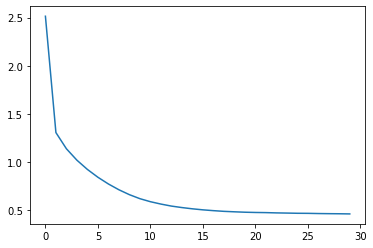

In [132]:
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
plt.plot(model.history.epoch, model.history.history['loss'])

In [ ]:
X.shape

In [67]:
hooray.shape

(1455, 45, 2)

In [69]:
hooray[0]

array([[ 10,   3],
       [ 11,   2],
       [  2,   2],
       [  7,   3],
       [ 40,   2],
       [231,   3],
       [118,   2],
       [ 13,   2],
       [ 12,   2],
       [  9,   2],
       [ 94,   3],
       [ 96,   2],
       [  3,   1],
       [388,   3],
       [  1,   4],
       [222,   3],
       [127,   2],
       [129,   2],
       [389,   0],
       [210,   0],
       [ 26,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0]], dtype=int32)

In [158]:
frame

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
41077,18/FA,MU 122 A-ES,Music in Film,F,1.0,3.0,A,3.0,3.667,Jeremy Grall,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41078,18/FA,MFS 100 A,Intro to Media Studies,F,1.0,3.0,A,3.0,3.667,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41079,18/FA,EH 102 A,Sem Critical Thinking Writing,F,1.0,3.0,B,3.0,3.667,Jane Archer,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41081,19/SP,PY 101 C,Introduction to Psychology,F,1.0,NaN,C,4.0,2.500,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41080,19/SP,MFS 220 A-CE,Film Production I,F,1.0,4.0,A,4.0,2.500,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41082,19/SP,MU 114 A-CE,Class Voice,F,1.0,NaN,B,4.0,2.500,Paul Wolf,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41083,19/SP,EH 210 A-IA,Introduction to Fiction,F,1.0,NaN,D,4.0,2.500,Haden Bell,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


ValueError: Data cardinality is ambiguous:
  x sizes: 1455
  y sizes: 1
Please provide data which shares the same first dimension.

In [160]:
target = []
for s_id in student_ids:
    grad = df[df['alt_id'] == s_id].iloc[0].Graduated
    target.append(grad)
    
student_ids = df.alt_id.unique()
course_sequences = []
for s_id in student_ids:
    frame = df[df['alt_id'] == s_id]
    term_sequences = []
    for idx, val in enumerate(frame['Sttr Term'].unique()):
        term = frame[frame['Sttr Term'] == val].sort_values('course_title')
        course_group = term.course_title.str.replace(' ', '').str.cat(sep='')
        term_sequences.append(course_group)
    term_sequences = ' '.join(term_sequences)
    course_sequences.append(term_sequences)

In [168]:
term_sequences

'IntrotoMediaStudiesMusicinFilmSemCriticalThinkingWriting ClassVoiceFilmProductionIIntroductiontoFictionIntroductiontoPsychology'

In [170]:
course_sequences[0]

'GeneralStatisticsOrganismalBiologyPrinofMacroeconomicsSemCriticalThinkingWriting IntermediateSpanishIntermediateWritingIntrotoAmerGovt&PolMacroeconomics EuropeanCivilI(IA)FundofSpanishGrammarHowLanguageWorksPrinofMicroeconomics ExplorationProject AccountingIEconometricsEstrategiasParaLeerMicroeconomicsPre-DepartTopicsStudyAbroad'

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(course_sequences)
encoded_sequences = tokenizer.texts_to_sequences(course_sequences)
padded_course_sequences = pad_sequences(
encoded_sequences, maxlen=45, dtype='int32', padding='post',
truncating='post', value=0.0)
feature_encoder = OneHotEncoder(handle_unknown='ignore')
feature_ids = list(tokenizer.word_index.values())
feature_encoder.fit(np.array(feature_ids).reshape(-1,1))
feature_encoder.transform(np.array(padded_course_sequences[0]).reshape(-1,1)).reshape(-1,1)
padded_reshaped_courses = padded_course_sequences.reshape(1455, 45, 1)

model = Sequential()
input_layer = Input(shape=(80, 1))
sequential_1 = LSTM(64, activation='relu')
output_layer = Dense(1, activation='sigmoid')

model.add(input_layer)
model.add(sequential_1)
model.add(output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(padded_reshaped_courses, np.array(target), epochs=10)


pd.DataFrame(feature_encoder.transform(np.array(padded_course_sequences[0]).reshape(-1,1)).todense())
np.array(padded_course_sequences[0]).reshape(-1,1)

In [159]:
frame

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
41077,18/FA,MU 122 A-ES,Music in Film,F,1.0,3.0,A,3.0,3.667,Jeremy Grall,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41078,18/FA,MFS 100 A,Intro to Media Studies,F,1.0,3.0,A,3.0,3.667,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41079,18/FA,EH 102 A,Sem Critical Thinking Writing,F,1.0,3.0,B,3.0,3.667,Jane Archer,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41081,19/SP,PY 101 C,Introduction to Psychology,F,1.0,NaN,C,4.0,2.500,Greta Valenti,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41080,19/SP,MFS 220 A-CE,Film Production I,F,1.0,4.0,A,4.0,2.500,Robert Corna,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41082,19/SP,MU 114 A-CE,Class Voice,F,1.0,NaN,B,4.0,2.500,Paul Wolf,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
41083,19/SP,EH 210 A-IA,Introduction to Fiction,F,1.0,NaN,D,4.0,2.500,Haden Bell,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
